## x>50 scaling factor
Below I recreate scaling factor plots made for $x>95$ in *scaling_factor_spatial.ipynb* but for $x>50$ all days.

To run this, first need to run the following:
* Run `/jobs/theory_lapse/cesm/thesis_figs/scripts/load_ds_quant50_av.py` to create the file `/jobs/theory_lapse/cesm/thesis_figs/ds_processed/ds_quant50_av.nc`.
* Run `/jobs/theory_lapse/cesm/thesis_figs/scaling_factor_spatial.ipynb` to create the file `/jobs/theory_lapse/cesm/thesis_figs/ds_processed/all_ds_coarse_av_quant95.nc`.

In [1]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm.notebook import tqdm
from cartopy.util import add_cyclic_point
import copy
import matplotlib.colors as mcolors
from matplotlib.offsetbox import TextArea, HPacker, AnnotationBbox
from datatree import DataTree, open_datatree

from isca_tools.cesm import get_pressure
from isca_tools.convection.base import lcl_sigma_bolton_simple
import cartopy.crs as ccrs
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry, temp_kelvin_to_celsius
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory, get_sensitivity_factors
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.decomposition import scaled_k_means_single
from isca_tools.utils.ds_slicing import fold_coarsen
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc, isel_float
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
leg_handlelength = 1.5

In [3]:
# Load data from quant=95 generated in scaling_factor_spatial
path_quant95 = os.path.join(utils.out_dir, "all_ds_coarse_av_quant95.nc")
ds_quant95_all = open_datatree(path_quant95)
ds_quant95_av_global = ds_quant95_all['ds_av_global'].ds.load()
ds_quant95_lat = ds_quant95_all['ds_lat'].ds.load()
ds_quant95_spatial = ds_quant95_all['ds_spatial'].ds.load()
mask_loc = ds_quant95_all['mask_loc'].ds.mask_loc.load()
p_ft = float(ds_quant95_lat.p_ft)
temp_surf_lcl_calc = float(ds_quant95_lat.temp_surf_lcl_calc)
lat_min = ds_quant95_spatial.lat_min
lat_max = ds_quant95_spatial.lat_max

In [4]:
from jobs.theory_lapse.cesm.thesis_figs.scripts.load_ds_tropics import land_frac_thresh

ds_quant50 = xr.load_dataset(os.path.join(utils.out_dir, 'ds_quant50_av.nc')).isel(plev=0)
land_frac = xr.open_dataset(utils.invariant_data_path).LANDFRAC.load().reindex_like(ds_quant50.isel(co2=0),
                                                                                    method="nearest", tolerance=0.01)
ds_quant50['lsm'] = land_frac > land_frac_thresh
ds_quant50 = ds_quant50.rename_vars({'doy': 'mean_doy'})
ds_quant50['temp_ft_pos_anom_frac'] = ds_quant50['n_temp_ft_pos_anom'] / ds_quant50.n_sample
ds_quant50 = ds_quant50.drop_vars(['hyam', 'hybm', 'P0', 'time_ind', 'gw'])
ds_quant50['lat_weights'] = utils.lat_weights.where(ds_quant50['TREFHT'] > 0)

var_keep = [var for var in ds_quant50 if
            var in ds_quant95_spatial]  # onlu keep variables in both quant=50 and quant=95 datasets
ds_quant50_coarse = fold_coarsen(
    ds_quant50.sel(lat=slice(lat_min, lat_max)).expand_dims({'sample': [0]}),
    k_lat=ds_quant95_spatial.n_coarse_lat, k_lon=ds_quant95_spatial.n_coarse_lon)[var_keep]

ds_quant50_av_global = ds_quant50_coarse.where(mask_loc & ds_quant50_coarse.lsm
                                               ).weighted(ds_quant50_coarse.lat_weights).quantile(0.5,
                                                                                                  dim=['lon', 'sample',
                                                                                                       'lat'])
ds_quant50_lat = ds_quant50_coarse.where(mask_loc & ds_quant50_coarse.lsm).weighted(ds_quant50_coarse.lat_weights).mean(
    dim=['lon', 'sample'])
ds_quant50_spatial = ds_quant50_coarse.where(mask_loc & ds_quant50_coarse.lsm).weighted(
    ds_quant50_coarse.lat_weights).mean(dim='sample')

In [5]:
quant_vals = xr.DataArray([50, 95], dims="quant", name='quant')
var_av_global = [var for var in var_keep if var in ds_quant95_av_global]
ds_av_global = xr.concat([ds_quant50_av_global[var_av_global], ds_quant95_av_global[var_av_global]], dim=quant_vals)
var_lat = [var for var in var_keep if var in ds_quant95_lat]
ds_lat = xr.concat([ds_quant50_lat[var_lat], ds_quant95_lat[var_lat]], dim=quant_vals)
ds_spatial = xr.concat([ds_quant50_spatial, ds_quant95_spatial[var_keep]], dim=quant_vals)

In [6]:
# Print average quantities for quant=50
for key in ds_av_global:
    var = ds_av_global[key]
    if 'rh' in key:
        var = var * 100
    elif 'PREFHT' in key:
        var = var / 100
    print(f"{key} | {var.isel(co2=0, quant=0):.2f} | {var.diff(dim='co2').squeeze().isel(quant=0):.2f}")

TREFHT | 300.92 | 5.08
T_ft_env | 255.16 | 6.11
PREFHT | 961.86 | 0.92
rh_REFHT | 46.95 | -2.74
T_ft_env_zm | 253.89 | 6.04
T_ft_env_anom | 0.38 | 0.05


### Scaling factor contribution
Below I plot the zonal average scaling factor contributions for the non convective elements.

I have two types, `quant50` is just warming of x>50 at location relative to global average. `local` is warming of x>95 at a given location relative to x>50 at that location.

Think should just show first as familiar from main figures in chapter, exactly the same but just for more days.

In [7]:
# Get dimensionless sensitivity factors, always using quant=50 in preindustrial simulation
# So can put everything in scaling factor units
get_sensitivity_factors_xr = wrap_with_apply_ufunc(get_sensitivity_factors)
gamma_global_av = get_sensitivity_factors_xr(ds_av_global.isel(quant=0, co2=0).TREFHT,
                                             ds_av_global.isel(quant=0, co2=0).rh_REFHT,
                                             ds_av_global.isel(quant=0, co2=0).PREFHT, p_ft, temp_surf_lcl_calc)
gamma_global_av = xr.Dataset(utils.convert_ds_of_dicts(gamma_global_av, [0], 'blah')).isel(blah=0, drop=True)

gamma_lat = get_sensitivity_factors_xr(ds_lat.TREFHT.isel(quant=0, co2=0),
                                       ds_lat.rh_REFHT.isel(quant=0, co2=0),
                                       ds_lat.PREFHT.isel(quant=0, co2=0), p_ft, temp_surf_lcl_calc)
gamma_lat = xr.Dataset(utils.convert_ds_of_dicts(gamma_lat, [0], 'blah')).isel(blah=0, drop=True)

gamma_spatial = get_sensitivity_factors_xr(ds_spatial.TREFHT.isel(quant=0, co2=0),
                                           ds_spatial.rh_REFHT.isel(quant=0, co2=0),
                                           ds_spatial.PREFHT.isel(quant=0, co2=0), p_ft, temp_surf_lcl_calc)
gamma_spatial = xr.Dataset(utils.convert_ds_of_dicts(gamma_spatial, [0], 'blah')).isel(blah=0, drop=True)

In [8]:
var_sf = ['TREFHT', 'rh_REFHT', 'PREFHT', 'T_ft_env', 'T_ft_env_zm', 'T_ft_env_anom']


def get_sf_cont(ds, gamma, ds_av=ds_av_global, gamma_av=gamma_global_av, var_sf=var_sf,
                norm_by_ref_quant50=False, norm_by_ref_local=True):
    # ds_sf[0] is relative to spatial average
    # Initialize by taking difference with co2 and then remove average difference
    ds_sf = [ds.diff(dim='co2').isel(quant=0)[var_sf].squeeze()]
    if norm_by_ref_quant50:
        # Subtract difference in average
        ds_sf[0] = ds_sf[0] - ds_av.diff(dim='co2').isel(quant=0)[var_sf].squeeze()
    temp_av_change = ds_av['TREFHT'].isel(quant=0).diff(dim='co2').squeeze()
    ds_sf[0]['TREFHT'] = ds_sf[0]['TREFHT'] / temp_av_change  # this is just the actual scaling factor
    for key in [var for var in var_sf if 'T_ft' in var]:
        ds_sf[0][key] = gamma_av['temp_ft_change'] * ds_sf[0][key] / temp_av_change
    # Account for dimensions and sign when considering RH
    prefactor_rh = -gamma_av['rh_change'] * ds_av['TREFHT'].isel(quant=0, co2=0) / ds_av['rh_REFHT'].isel(quant=0,
                                                                                                          co2=0)
    ds_sf[0]['rh_REFHT'] = prefactor_rh * ds_sf[0]['rh_REFHT'] / temp_av_change
    # Account for dimensions when considering PREFHT
    prefactor_p = gamma_av['p_surf_change'] * ds_av['TREFHT'].isel(quant=0, co2=0) / ds_av['PREFHT'].isel(quant=0,
                                                                                                          co2=0)
    ds_sf[0]['PREFHT'] = prefactor_p * ds_sf[0]['PREFHT'] / temp_av_change
    if norm_by_ref_quant50:
        ds_sf[0] = ds_sf[0] + 1
    else:
        ds_sf[0]['rh_REFHT'] += 1
        ds_sf[0]['PREFHT'] += 1
        ds_sf[0]['T_ft_env_anom'] += 1
    # Anomaly mechanisms
    ds_sf[0]['rh_anom'] = -gamma_av['rh_anom'] * (ds.rh_REFHT.isel(quant=0, co2=0) - ds_av.rh_REFHT.isel(quant=0, co2=0)
                                                  ) / ds_av.rh_REFHT.isel(quant=0, co2=0) + 1
    ds_sf[0]['temp_surf_anom'] = gamma_av['temp_surf_anom'] * (
                ds.TREFHT.isel(quant=0, co2=0) - ds_av.TREFHT.isel(quant=0, co2=0)
                ) / ds_av.TREFHT.isel(quant=0, co2=0) + 1
    ds_sf[0]['p_surf_anom'] = -gamma_av['p_surf_anom'] * (
                ds.PREFHT.isel(quant=0, co2=0) - ds_av.PREFHT.isel(quant=0, co2=0)
                ) / ds_av.PREFHT.isel(quant=0, co2=0) + 1

    # ds_sf[1] is local x=95 relative to x=50
    ds_sf.append(ds[var_sf].isel(quant=1).diff(dim='co2').squeeze())
    if norm_by_ref_local:
        ds_sf[1] = ds_sf[1] - ds[var_sf].isel(quant=0).diff(dim='co2').squeeze()
    temp_av_change = ds['TREFHT'].isel(quant=0).diff(dim='co2').squeeze()  # Now reference is quant=50 at that loc
    ds_sf[1]['TREFHT'] = ds_sf[1]['TREFHT'] / temp_av_change  # this is just the actual scaling factor
    for key in [var for var in var_sf if 'T_ft' in var]:
        ds_sf[1][key] = gamma_global_av['temp_ft_change'] * ds_sf[1][key] / temp_av_change
    # Account for dimensions when considering RH
    prefactor_rh = -gamma['rh_change'] * ds['TREFHT'].isel(quant=0, co2=0) / ds['rh_REFHT'].isel(quant=0, co2=0)
    ds_sf[1]['rh_REFHT'] = prefactor_rh * ds_sf[1]['rh_REFHT'] / temp_av_change
    # Account for dimensions when considering PREFHT
    prefactor_p = gamma['p_surf_change'] * ds['TREFHT'].isel(quant=0, co2=0) / ds['PREFHT'].isel(quant=0, co2=0)
    ds_sf[1]['PREFHT'] = prefactor_p * ds_sf[1]['PREFHT'] / temp_av_change
    if norm_by_ref_local:
        ds_sf[1] = ds_sf[1] + 1
    else:
        ds_sf[1]['rh_REFHT'] += 1
        ds_sf[1]['PREFHT'] += 1
        ds_sf[1]['T_ft_env_anom'] += 1
    # Anomaly mechanisms
    ds_sf[1]['rh_anom'] = -gamma['rh_anom'] * \
                          ds.rh_REFHT.isel(co2=0).diff(dim='quant').squeeze() / ds.rh_REFHT.isel(quant=0, co2=0) + 1
    ds_sf[1]['temp_surf_anom'] = gamma['temp_surf_anom'] * \
                                 ds.TREFHT.isel(co2=0).diff(dim='quant').squeeze() / ds.TREFHT.isel(quant=0, co2=0) + 1
    ds_sf[1]['p_surf_anom'] = -gamma['p_surf_anom'] * \
                              ds.PREFHT.isel(co2=0).diff(dim='quant').squeeze() / ds.PREFHT.isel(quant=0, co2=0) + 1
    ds_sf = xr.concat(ds_sf, xr.DataArray(['quant50', 'local'], dims="type", name='type'))
    ds_sf['scale_factor_sum'] = (ds_sf - 1).to_array(dim="variable").sum("variable")
    ds_sf['scale_factor_sum'] = ds_sf['scale_factor_sum'] - ds_sf['TREFHT'] + 2
    return ds_sf

### Zonal Average
Below I plot the zonal average scaling factor contributions for the non convective elements.

In [9]:
ds_sf_lat = get_sf_cont(ds_lat, gamma_lat, norm_by_ref_local=True)

In [43]:
style_map = copy.deepcopy(utils.style_map_cont)
style_map['TREFHT'] = list(style_map.pop('scale_factor'))
style_map['T_ft_env'] = style_map.pop('temp_ft_change')
style_map['rh_REFHT'] = style_map.pop('rh_change')
style_map['PREFHT'] = style_map.pop('p_surf_change')

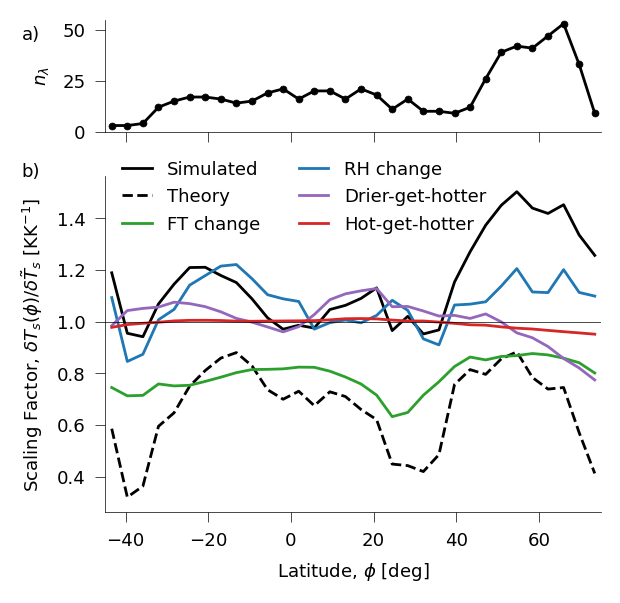

In [45]:
# Ensure when averaging over latitude for each quant, that weight the more convective latitudes more
thresh_sf_individual = 0.04
label_lat = 'Latitude, $\phi$ [deg]'
label_sf_zm = utils.sf_label.replace('x', '\phi').replace('overline',
                                                          'tilde')  # tilde because use overline later in spatial, slightly different
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
fig_resize(fig, width['one_col'], ar=2)
ax[0].plot(mask_loc.lat, mask_loc.sum(dim='lon'), color='k', marker='o')
ax[0].set_ylim(0, 55)
ax[0].set_yticks([0, 25, 50])
ax[0].set_ylabel('$n_{\lambda}$')

# ax.plot(ds_sf_num.quant,
#         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
#         color='k', linestyle='--', label='Linear + nl_r_change')
for key in ['TREFHT', 'scale_factor_sum', 'T_ft_env', 'rh_REFHT', 'PREFHT', 'rh_anom', 'temp_surf_anom', 'p_surf_anom']:
    if key in ['T_ft_env_zm', 'T_ft_env_anom']:
        continue
    if np.nanmax(np.abs(ds_sf_lat[key].isel(type=0) - 1)) < 0.04:
        continue
    ax[1].plot(ds_sf_lat.lat, ds_sf_lat[key].isel(type=0), label=style_map[key][2],
               color=style_map[key][0],
               linestyle=style_map[key][1])

update_linewidth(fig)
ax[1].legend(ncol=2, handlelength=leg_handlelength, bbox_to_anchor=(0, 1.1), loc='upper left')
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[1].set_xlabel(label_lat)
ax[1].set_ylabel(label_sf_zm)
ax[1].set_xlim(lat_min, lat_max)
# ax[1].set_ylim(0.5, 1.5)
# ax[0].legend(ncol=2)
label_subplots(fig, ax[0], pos_x=-30, box_alpha=0, pos_y=-2, labels=['a)'])
label_subplots(fig, ax[1], pos_x=-30, box_alpha=0, pos_y=5, labels=['b)'])
update_fontsize(fig, 6.5)
plt.show()
# savefig(fig)

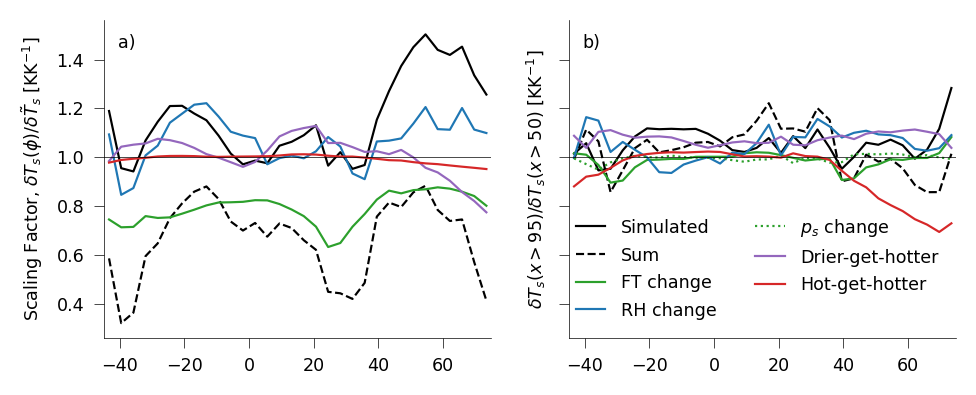

In [12]:
# Also include local scaling factor - think too complicated
label_lat = 'Latitude, $\phi$ [deg]'
label_sf_zm = [utils.sf_label.replace('x', '\phi').replace('overline', 'tilde'),
               utils.sf_label.replace('x', 'x>95').replace('\overline{T}_s', 'T_s(x>50)').replace('Scaling Factor, ',
                                                                                                  '')]  # tilde because use overline later in spatial, slightly different

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])

for i in range(ds_sf_lat.type.size):
    for key in ['TREFHT', 'scale_factor_sum', 'T_ft_env', 'rh_REFHT', 'PREFHT', 'rh_anom', 'temp_surf_anom',
                'p_surf_anom']:
        if key in ['T_ft_env_zm', 'T_ft_env_anom']:
            continue
        if np.nanmax(np.abs(ds_sf_lat[key].isel(type=i) - 1)) < 0.04:
            continue
        ax[i].plot(ds_lat.lat, ds_sf_lat[key].isel(type=i), label=style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])
    ax[i].set_ylabel(label_sf_zm[i])
#
update_linewidth(fig)
ax[1].legend(ncol=2, handlelength=leg_handlelength)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
# ax[1].set_xlabel(label_lat)
# ax[1].set_ylabel(label_sf_zm)
ax[0].set_xlim(lat_min, lat_max)
# ax[1].set_ylim(0.5, 1.5)
# # ax[0].legend(ncol=2)
# label_subplots(fig, ax[0], pos_x=-30, box_alpha=0, pos_y=-2, labels=['a)'])
# label_subplots(fig, ax[1], pos_x=-30, box_alpha=0, pos_y=5, labels=['b)'])
label_subplots(fig, ax)
update_fontsize(fig)
plt.show()
# savefig(fig)

### Spatial scaling factor
Below I recreate figures for x>50 spatial scaling factor.

This is identical code to that used to create the figures in *scaling_factor_spatial.ipynb* for x>95.

In [13]:
def plot_scatter_mask(mask, ax, s=12, color='k', marker='.', zorder=20, edgecolors='None', linewidths=1.0):
    # Cyclic versions of BOTH data and mask along lon axis=1
    mask_c, lon_c = add_cyclic_point(mask.values.astype(int), coord=mask["lon"].values, axis=1)  # [web:66]
    mask_c = mask_c.astype(bool)

    # Scatter where True (now indices match lon_c)
    iy, ix = np.where(mask_c)

    lon_pts = lon_c[ix]
    lat_pts = mask["lat"].values[iy]

    return ax.scatter(lon_pts, lat_pts, transform=ccrs.PlateCarree(),
                      s=s, marker=marker, facecolors=color, edgecolors=edgecolors, zorder=zorder, linewidths=linewidths)

In [14]:
for key in ['lapse_D', 'lapse_M', 'rh_mod']:
    ds_spatial[key] = ds_spatial['PREFHT'] * 0
    ds_av_global[key] = ds_av_global['PREFHT'] * 0

In [15]:
norm_by_av_spatial = True  # so change mechanisms normalized about 1
ds_sf_spatial = []
for i in tqdm(range(ds_spatial.lat.size)):
    ds_sf_spatial.append(
        utils.apply_sf_theory_with_rh_mod(ds_spatial.isel(lat=i, quant=0), ds_av_global.isel(quant=0), p_ft,
                                          temp_surf_lcl_calc,
                                          quant_dim='lon', numerical=False))
ds_sf_spatial = xr.concat(ds_sf_spatial, dim=ds_spatial.lat)
if norm_by_av_spatial:
    # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
    ds_sf_av_spatial = utils.apply_sf_theory_with_rh_mod(
        ds_av_global.expand_dims({"newdim": [0]}).isel(quant=0), ds_av_global.isel(quant=0), p_ft, temp_surf_lcl_calc,
        quant_dim='newdim', numerical=False).isel(newdim=0, drop=True)
    for key in ds_sf_spatial:
        ds_sf_spatial[key] = ds_sf_spatial[key] - ds_sf_av_spatial[key] + 1

path_output_sf_spatial_num = os.path.join(utils.out_dir, 'ds_sf_spatial_global.nc')
if os.path.exists(path_output_sf_spatial_num):
    ds_sf_spatial_num = xr.load_dataset(path_output_sf_spatial_num)
else:
    # Takes 10 mins for 4 x 4 grid
    ds_sf_spatial_num = []
    for i in tqdm(range(ds_spatial.lat.size)):
        ds_sf_spatial_num.append(
            utils.apply_sf_theory_with_rh_mod(ds_spatial.isel(lat=i, quant=0), ds_av_global.isel(quant=0),
                                              p_ft, temp_surf_lcl_calc, quant_dim='lon', numerical=True))
    ds_sf_spatial_num = xr.concat(ds_sf_spatial_num, dim=ds_spatial.lat)
    # ds_spatial = xr.
    if norm_by_av_spatial:
        # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
        ds_sf_av_spatial_num = \
            utils.apply_sf_theory_with_rh_mod(ds_av_global.expand_dims({"newdim": [0]}).isel(quant=0),
                                              ds_av_global.isel(quant=0),
                                              p_ft, temp_surf_lcl_calc, quant_dim='newdim',
                                              numerical=True).isel(newdim=0, drop=True)
        for key in ds_sf_spatial_num:
            ds_sf_spatial_num[key] = ds_sf_spatial_num[key] - ds_sf_av_spatial_num[key] + 1

  0%|          | 0/32 [00:00<?, ?it/s]

In [16]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_spatial_num["nl_sum"] = ds_sf_spatial_num['scale_factor_nl'] - ds_sf_spatial_num['scale_factor_linear'] + 1
# Set numerical method to show difference to linear theory
for key in ds_sf_spatial:
    if 'scale_factor_sum' in key:
        continue
    if 'rh_mod' in key:
        continue
    if 'rh' in key:
        # combine physical and mod linear contributions as done in numerical
        var = ds_sf_spatial[key] + ds_sf_spatial[key.replace('rh', 'rh_mod')] - 1
    else:
        var = ds_sf_spatial[key]
    ds_sf_spatial_num[key] = ds_sf_spatial_num[key] - var + 1

In [17]:
# Compute scale factor from just hange contribution or just anom contribution
var_names_change = [key for key in ds_sf_spatial if not
(('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('nl' in key) or ('anom' in key))]
var_names_anom = [key for key in ds_sf_spatial if not
(('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('nl' in key) or ('change' in key))]
ds_sf_spatial['scale_factor_change'] = (ds_sf_spatial[var_names_change].to_array(dim="feature") - 1).sum(
    dim='feature') + 1
ds_sf_spatial['scale_factor_anom'] = (ds_sf_spatial[var_names_anom].to_array(dim="feature") - 1).sum(dim='feature') + 1

In [18]:
# Indicate where non-linear anom mechanisms important - all locations important are where rh_anom important
thresh_mask_nl = 0.2
mask_nl_anom = ds_sf_spatial_num.scale_factor < 0
for key in ds_sf_spatial_num:
    if ('scale_factor' in key) or ('sum' in key) or ('error' in key) or ('change' in key) or ('residual' in key):
        continue
    if (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl).any():
        print(key, (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl).sum().values)
        mask_nl_anom = mask_nl_anom | (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl)
# mask_non_rh_anom = mask_non_rh_anom | (np.abs(ds_sf_spatial.p_surf_anom - 1) > thresh_mask_anom) | \
#                    (np.abs(ds_sf_spatial.temp_surf_anom - 1) > thresh_mask_anom)
mask_nl_anom = mask_nl_anom & mask_loc
# mask_nl_anom = mask_loc & (np.abs(ds_sf_spatial_num['rh_anom'] - 1) > thresh_mask_nl)

# Indicate where non-linear change mechanisms important
mask_nl_change = ds_sf_spatial_num.scale_factor < 0
for key in ds_sf_spatial_num:
    if ('scale_factor' in key) or ('sum' in key) or ('error' in key) or ('change' not in key):
        continue
    mask_nl_change = mask_nl_change | (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl)
mask_nl_change = mask_loc & mask_nl_change

temp_surf_anom 7
rh_anom 24
nl_temp_surf_anom_rh_anom 20


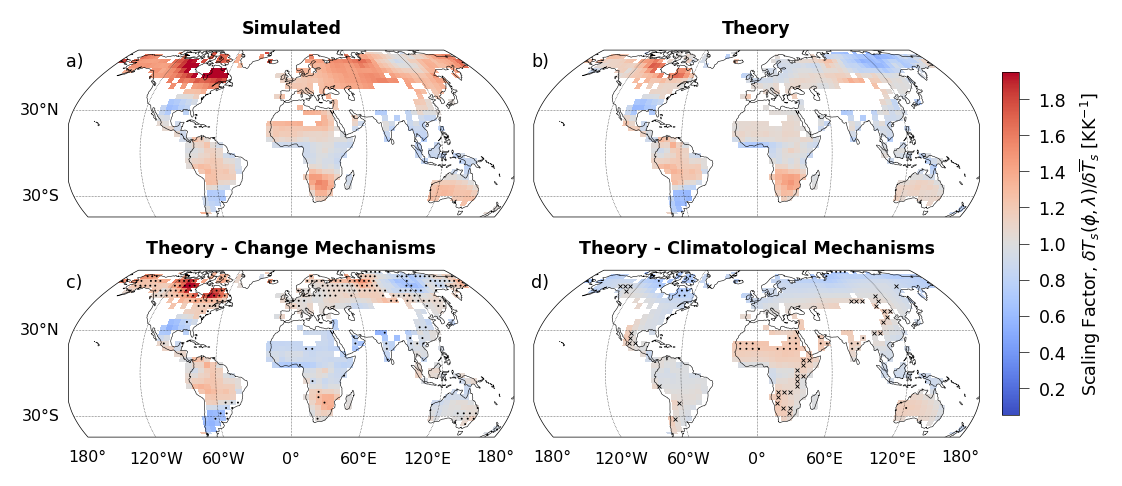

In [40]:
gl_fontsize = 5.74
label_sf_spatial = utils.sf_label.replace('x', '\phi, \lambda')
sf_clim = [0.05, 1.95]
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
fig_resize(fig, width['two_col'], ar=2.4)
for i, ax_use in enumerate(ax.flatten()):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.2, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i <= 1:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False
utils.plot_contour_projection(ax[0, 0], ds_sf_spatial.scale_factor.where(mask_loc), cmap='coolwarm',
                              imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1],
                                                          'extent': (0, 360, lat_min, lat_max)})
utils.plot_contour_projection(ax[0, 1], ds_sf_spatial.scale_factor_sum.where(mask_loc),
                              cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1],
                                                                           'extent': (0, 360, lat_min, lat_max)})
utils.plot_contour_projection(ax[1, 0], ds_sf_spatial.scale_factor_change.where(mask_loc),
                              cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1],
                                                                           'extent': (0, 360, lat_min, lat_max)})
im = utils.plot_contour_projection(ax[1, 1], ds_sf_spatial.scale_factor_anom.where(mask_loc),
                                   cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1],
                                                                                'extent': (0, 360, lat_min, lat_max)})

# Indicate where nl mechanisms important
plot_scatter_mask(mask_nl_change, ax[1, 0], s=2)
plot_scatter_mask(mask_nl_anom, ax[1, 1], s=2)

# Indicate where non drier-get-hotter mechanism important. I think only these two have contribution of magnitude greater than 0.05.
# No negative contributions have contribution less than -0.05.
plot_scatter_mask(np.abs(ds_sf_spatial.rh_mod_anom - 1) > 0.06, ax[1, 1], s=2, marker='+', linewidths=0.3)
plot_scatter_mask(np.abs(ds_sf_spatial.p_surf_anom - 1) > 0.06, ax[1, 1], s=2, marker='x', linewidths=0.3)

label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-1, pos_x=-1)
plt.colorbar(im, ax=ax[:, 1].ravel(), label=label_sf_spatial, shrink=0.85, ticks=np.arange(0.2, 2, 0.2))
ax[0, 0].set_title('Simulated', fontweight='bold')
ax[0, 1].set_title('Theory', fontweight='bold')
ax[1, 0].set_title('Theory - Change Mechanisms', fontweight='bold')
ax[1, 1].set_title('Theory - Climatological Mechanisms', fontweight='bold')
update_fontsize(fig)
plt.show()
# savefig(fig)

### Individual Change mechanisms
Only show FT change and RH change as pressure change is not important.

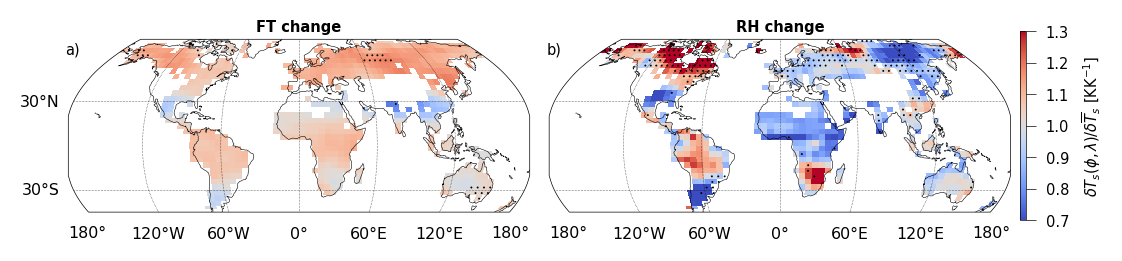

In [41]:
var_order = ['temp_ft', 'rh']
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(1, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
fig_resize(fig, width['two_col'], ar=2.4 * 2)
for i, ax_use in enumerate(ax):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.2, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i == 1:
        gl.left_labels = False
    ax_use.set_title(utils.labels_cont[f"{var_order[i]}_change"], fontweight='bold', y=0.95)
    im = utils.plot_contour_projection(ax_use, ds_sf_spatial[f"{var_order[i]}_change"].where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs={'vmin': 0.7, 'vmax': 1.3,
                                                      'extent': (0, 360, lat_min, lat_max)})
    mask_nl_use = np.abs(ds_sf_spatial_num[f"{var_order[i]}_change"] - 1) > thresh_mask_nl
    if mask_nl_anom.any():
        plot_scatter_mask(mask_nl_use, ax_use, s=2)
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-1, pos_x=-1)
plt.colorbar(im, ax=ax.ravel(), label=label_sf_spatial.replace('Scaling Factor, ', ''), ticks=np.arange(0.7, 1.4, 0.1),
             pad=0.01, aspect=30)
update_fontsize(fig)
plt.show()
# savefig(fig)

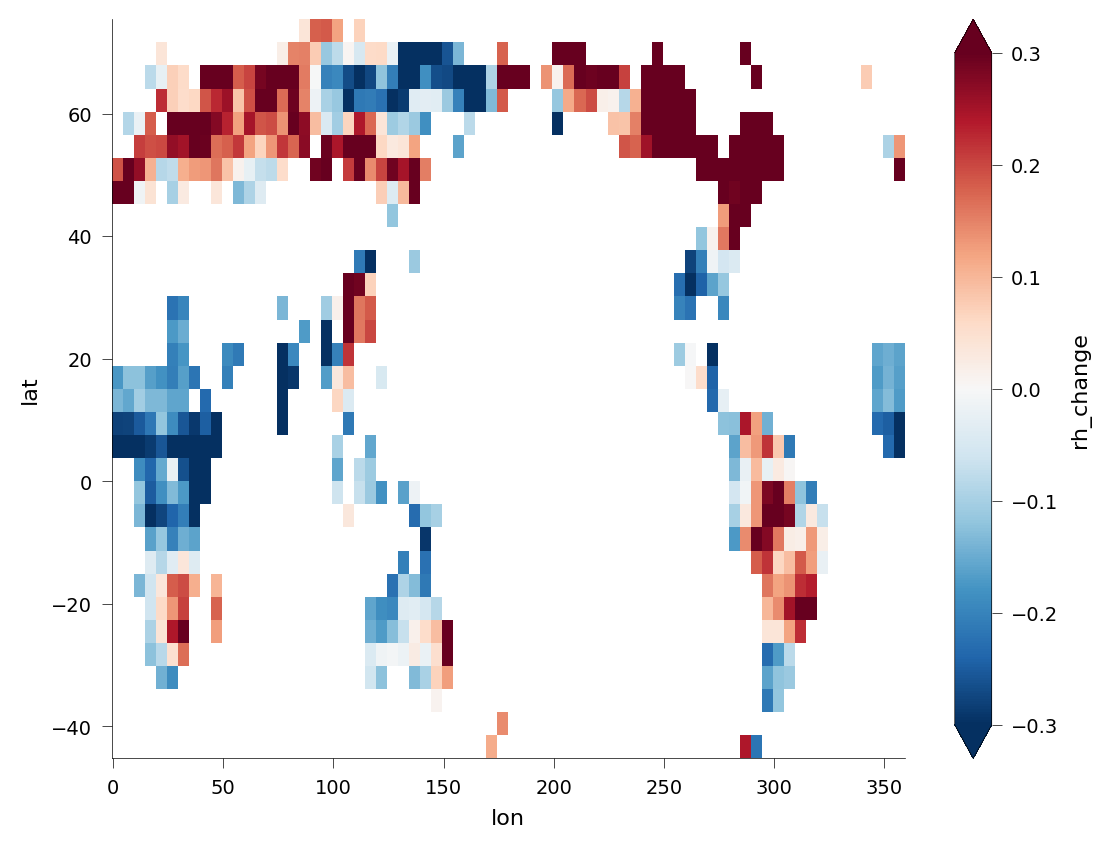

In [63]:
(ds_sf_spatial_num[f"rh_change"] + ds_sf_spatial[f"rh_change"] - 2).plot(vmax=0.3)

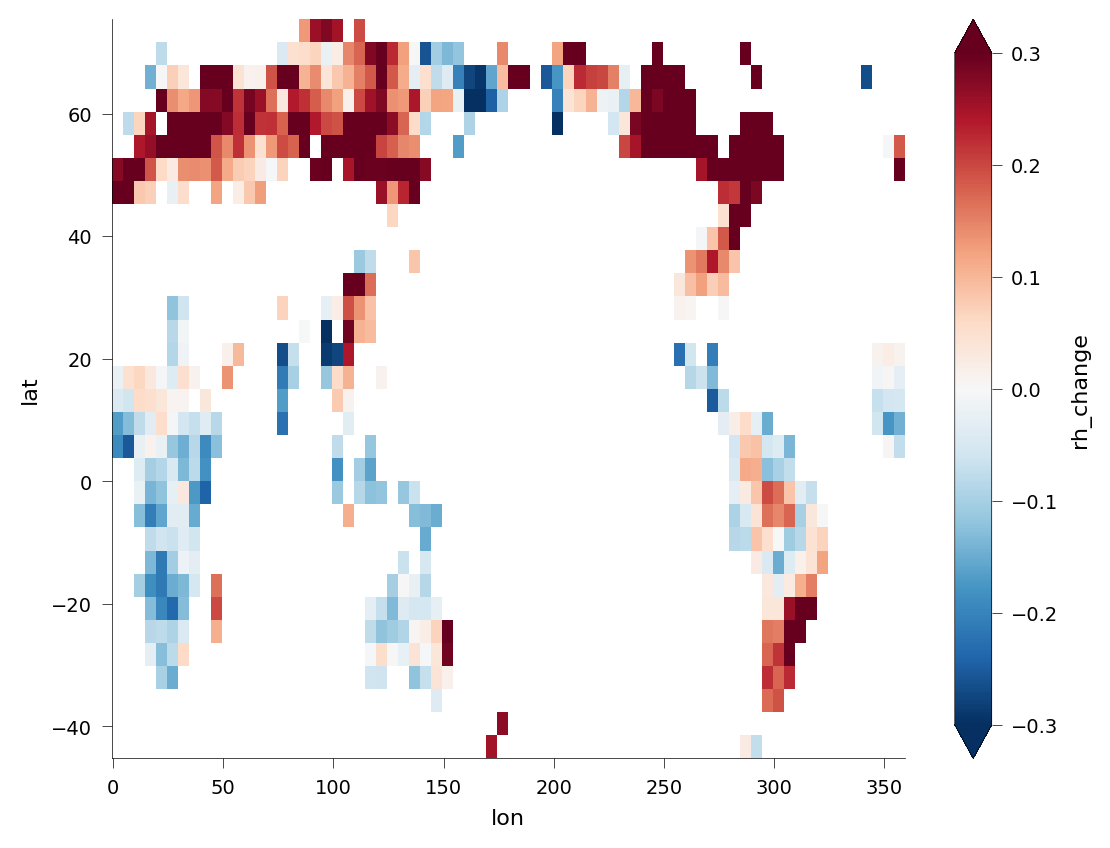

In [50]:
(ds_sf_spatial_num[f"rh_change"] - 1).plot(vmax=0.3)

### Free Troposphere Decomposition

In [33]:
# Find sensitivity factor, gamma_ft, from full temp_ft contribution
# Use this to obtain the zonal mean and anomaly contribution
if norm_by_av_spatial:
    gamma_ft = (ds_sf_spatial.temp_ft_change + ds_sf_av_spatial.temp_ft_change - 1) / ds_spatial.isel(quant=0).T_ft_env.diff(
        dim='co2')
    temp_ft_zm_sf_cont = gamma_ft * (
            ds_spatial.T_ft_env_zm.diff(dim='co2') - ds_av_global.T_ft_env_zm.diff(dim='co2')) + 1
    temp_ft_zm_sf_cont = temp_ft_zm_sf_cont.isel(quant=0)
    temp_ft_anom_sf_cont = gamma_ft * (
            ds_spatial.T_ft_env_anom.diff(dim='co2') - ds_av_global.T_ft_env_anom.diff(dim='co2')) + 1
    temp_ft_anom_sf_cont = temp_ft_anom_sf_cont.isel(quant=0)
else:
    gamma_ft = ds_sf_spatial.temp_ft_change / ds_spatial.isel(quant=0).T_ft_env.diff(dim='co2').isel(quant=0)
    temp_ft_zm_sf_cont = gamma_ft * ds_spatial.T_ft_env_zm.diff(dim='co2').isel(quant=0)
    temp_ft_anom_sf_cont = gamma_ft * ds_spatial.T_ft_env_anom.diff(dim='co2').isel(quant=0)
gamma_ft = gamma_ft.squeeze()
temp_ft_zm_sf_cont = temp_ft_zm_sf_cont.squeeze()
temp_ft_anom_sf_cont = temp_ft_anom_sf_cont.squeeze()

In [35]:
# The zonal mean temp_ft change arises either from change with warming on the given day, or a change in the day with warming
# and keep current climate. Those two cases are obtained here.
# temp_ft_zm_coarse = temp_ft_zm.where((ds.TREFHT.isel(sample=[0], lon=[0]) > 0).isel(co2=0))
temp_ft_zm = xr.concat([xr.load_dataset(os.path.join(utils.out_dir, f"ds_t400_climatology_{exp_name}.nc"))
                        for exp_name in utils.exp_names], dim=ds_lat.co2).T.sel(plev=ds_lat.p_ft, drop=True)
temp_ft_zm_coarse = temp_ft_zm.expand_dims(dim={'sample': [0], 'lon': [0]})
temp_ft_zm_coarse = \
    fold_coarsen(xr.Dataset({'var': temp_ft_zm_coarse}).sel(lat=slice(lat_min, lat_max)), k_lat=ds_quant95_lat.n_coarse_lat,
                 k_lon=1
                 ).mean(dim='sample').squeeze()['var'].drop_vars('lon')

lat2d = xr.broadcast(temp_ft_zm_coarse["lat"], ds_spatial["lon"])[0]  # (lat, lon)
temp_ft_zm_coarse_change_day = []
temp_ft_zm_coarse_same_day = []
for i in range(ds_spatial.co2.size):
    temp_ft_zm_coarse_change_day.append(
        temp_ft_zm_coarse.isel(co2=0).sel(dayofyear=ds_spatial.mean_doy.isel(co2=i, quant=0).astype(int),
                                          lat=lat2d, method="nearest"))
    temp_ft_zm_coarse_same_day.append(
        temp_ft_zm_coarse.isel(co2=i).sel(dayofyear=ds_spatial.mean_doy.isel(co2=0, quant=0).astype(int),
                                          lat=lat2d, method="nearest"))
temp_ft_zm_coarse_change_day = xr.concat(temp_ft_zm_coarse_change_day, dim=ds_spatial.co2)
temp_ft_zm_coarse_same_day = xr.concat(temp_ft_zm_coarse_same_day, dim=ds_spatial.co2)

Correlation of (b) with (f): 0.81


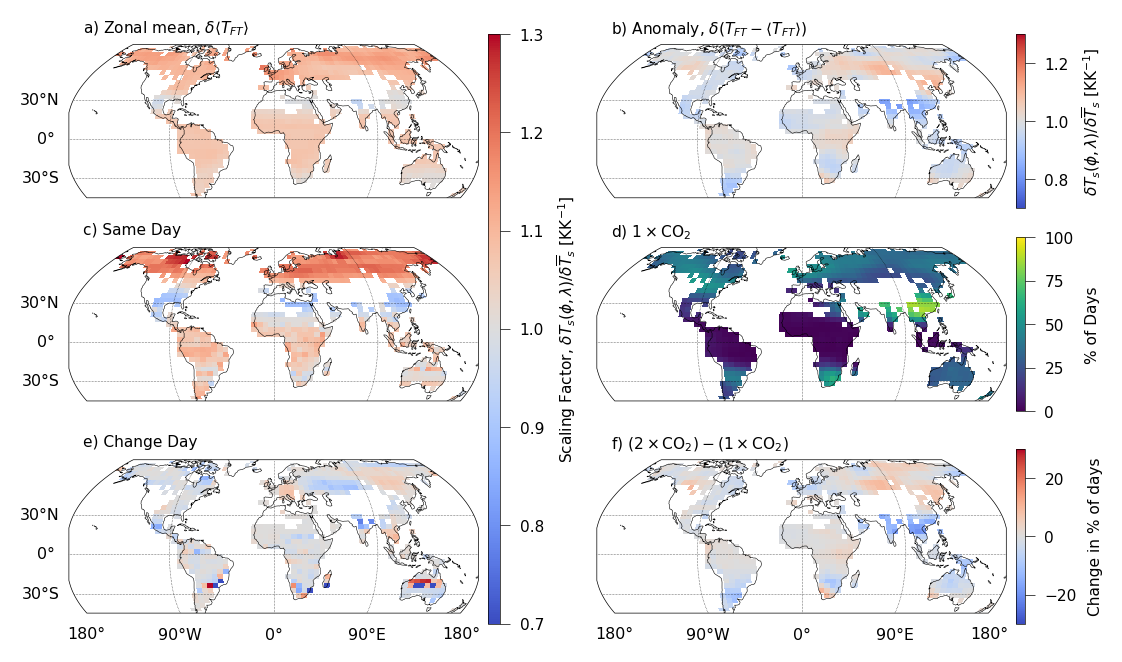

In [42]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
fig_resize(fig, width['two_col'], ar=1.3)
for i in range(len(ax.flatten())):
    gl = utils.initialize_ax_projection(ax.flatten()[i], lat_min=lat_min, lat_max=lat_max, auto_aspect=True,
                                        grid_lat=[-30, 0, 30],
                                        grid_lon=[-180, -90, 0, 90, 180], return_gl=True, gridline_lw=0.2,
                                        coastline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i < 4:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False


# Zonal Av breakdown
imshow_args_use = {'vmin': 0.7, 'vmax': 1.3,
                   'extent': (0, 360, lat_min, lat_max)}
im = utils.plot_contour_projection(ax[0, 0], temp_ft_zm_sf_cont.where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs=imshow_args_use)

var = gamma_ft * (temp_ft_zm_coarse_same_day.diff(dim='co2') - ds_av_global.isel(quant=0).T_ft_env_zm.diff(dim='co2')).squeeze() + 1
im = utils.plot_contour_projection(ax[1, 0], var.where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs=imshow_args_use)
var = gamma_ft * temp_ft_zm_coarse_change_day.diff(dim='co2').squeeze() + 1
im = utils.plot_contour_projection(ax[2, 0], var.where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs=imshow_args_use)
plt.colorbar(im, ax=ax[:, 0].ravel(), label=label_sf_spatial, pad=0.02, fraction=0.1, aspect=50)



# Anomaly breakdown
im = utils.plot_contour_projection(ax[0, 1], temp_ft_anom_sf_cont.where(mask_loc),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs=imshow_args_use)
plt.colorbar(im, ax=ax[0, 1], label=label_sf_spatial.replace('Scaling Factor, ', ''), pad=0.02, fraction=0.1, aspect=20)

imshow_args_use = {'vmin': 0, 'vmax': 100,
                   'extent': (0, 360, lat_min, lat_max)}
im = utils.plot_contour_projection(ax[1, 1], ds_spatial['temp_ft_pos_anom_frac'].isel(co2=0, quant=0).where(mask_loc)*100,
                                   cmap='viridis', imshow=True,
                                   imshow_kwargs=imshow_args_use)
plt.colorbar(im, ax=ax[1, 1], label='% of Days', pad=0.02, fraction=0.1, aspect=20)
imshow_args_use = {'vmin': -30, 'vmax': 30,
                   'extent': (0, 360, lat_min, lat_max)}
im = utils.plot_contour_projection(ax[2, 1], ds_spatial.isel(quant=0)['temp_ft_pos_anom_frac'].diff(dim='co2').squeeze().where(mask_loc)*100,
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs=imshow_args_use)
plt.colorbar(im, ax=ax[2, 1], label="Change in % of days", pad=0.02, fraction=0.1, aspect=20)


label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=9,
               labels=["a) Zonal mean, $\delta \langle T_{FT}\\rangle$", "b) Anomaly, $\delta \left(T_{FT} - \langle T_{FT}\\rangle\\right)$",
                       "c) Same Day", "d) $1\\times \\text{CO}_2$", "e) Change Day",
                       "f) $(2\\times \\text{CO}_2) - (1\\times \\text{CO}_2)$"])
update_fontsize(fig)

# Correlation between top and bottom above to show can link the two
var = xr.corr(ds_spatial.isel(quant=0)['temp_ft_pos_anom_frac'].diff(dim='co2').squeeze().where(mask_loc), temp_ft_anom_sf_cont.where(mask_loc)-1)
print(f"Correlation of (b) with (f): {var:.2f}")

plt.show()
# savefig(fig)